# Understanding Seasonality type 

In [1]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

#Reading the data
monthly_data = pd.read_csv("/Users/gautamchauhan21/social cops/Analysis-of-Agricultural-data/monthly_data_1.csv")
mandi_data = pd.read_csv("/Users/gautamchauhan21/social cops/Analysis-of-Agricultural-data/mandi_data_1.csv")

### Keeping only clusters of APMC and Commodity which have data present for atleast an year

In [2]:
monthly_data['date'] = pd.to_datetime(monthly_data.date) 

monthly_data = monthly_data.drop(['state_name','Month'],axis=1)
monthly_data.reset_index(inplace=True,drop=True)
monthly_data['month'] = pd.DatetimeIndex(monthly_data['date']).month

In [3]:
monthly_data.dtypes

APMC                       object
Commodity                  object
Year                        int64
arrivals_in_qtl             int64
min_price                   int64
max_price                   int64
modal_price                 int64
date               datetime64[ns]
district_name              object
month                       int64
dtype: object

In [4]:
grouped = monthly_data.groupby(['Commodity','APMC','Year']).date.agg('count').to_frame('count')
grouped = grouped.reset_index()
grouped["joined"]=grouped["Commodity"]+"_"+grouped["APMC"]
grouped = grouped[grouped['count']==12]
joined = list(grouped.joined.unique())


monthly_data["joined"]=monthly_data["Commodity"]+"_"+monthly_data["APMC"]
joined = list(grouped.joined.unique())
monthly_data=monthly_data[monthly_data["joined"].isin(joined)].reset_index(drop=True)

### Applying ADF as a unit root test

In [5]:
import statsmodels.tsa.stattools as ts


def augmented_dickey_fuller_test(df):
    stationary = []
    non_stat = []
    apmc_comm = list(df['joined'].unique())
    for ac in apmc_comm:
        temp = df.loc[df['joined']==ac]
        x = temp.modal_price.values
        result = ts.adfuller(x,1)
        p_value = result[1]
        if p_value > 0.05:
            non_stat.append(ac) #Requires Differencing
        else:
            stationary.append(ac) #Does not require differencing
    return non_stat,stationary

ns,s = augmented_dickey_fuller_test(monthly_data)

In [6]:
print("Number of stationary series with respect to APMC and Commodity:",len(s))
print("Number of non-stationary series are:",len(ns))

Number of stationary series with respect to APMC and Commodity: 535
Number of non-stationary series are: 175


In [7]:
monthly_data = monthly_data.sort_values(by=['date'])
stationary = monthly_data[monthly_data["joined"].isin(s)].reset_index(drop=True)
stationary.head()

,APMC,Commodity,Year,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,month,joined
0,jalgaon jamod-aasalgaon,pigeon pea (tur),2014,1300,4267,4833,4550,2014-09-01,Buldhana,9,pigeon pea (tur)_jalgaon jamod-aasalgaon
1,umared,pigeon pea (tur),2014,20,4161,4483,4322,2014-09-01,Nagpur,9,pigeon pea (tur)_umared
2,kopargaon,maize,2014,59,990,1165,1061,2014-09-01,Ahmadnagar,9,maize_kopargaon
3,kopargaon,gram,2014,428,2087,2668,2493,2014-09-01,Ahmadnagar,9,gram_kopargaon
4,umared,gram,2014,612,2526,2789,2657,2014-09-01,Nagpur,9,gram_umared


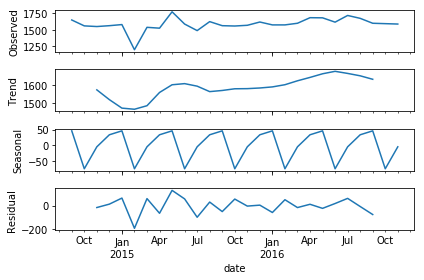

Shows a seasonal component of 50 rupees, which proves how naive seasonal_decompose() function of python is!


In [8]:
#Decomposing time series of Commodity = Bajri and APMC = Akole
temp = stationary[stationary.joined=='bajri_akole']
temp = temp[['modal_price','date']]
temp.set_index('date', inplace=True)
result = seasonal_decompose(temp.modal_price,freq=4)
result.plot()
plt.show()
print("Shows a seasonal component of 50 rupees, which proves how naive seasonal_decompose() function of \
python is!")

In [9]:
#Detrending the stationary series--

stationary['j_date'] = stationary["joined"]+"_"+stationary["Year"].apply(str)+"_"+stationary["month"].apply(str)
def detrend(df,s):
    final=pd.DataFrame()
    for t in s:
        temp = df.loc[df['joined']==t]
        temp = temp[["modal_price","j_date","date"]] 
        temp.set_index('date', inplace=True)
        cycle, trend = sm.tsa.filters.hpfilter(temp.modal_price,1600)
        temp["cycle"] = cycle
        temp["trend"] = trend
        res = df.merge(temp, on=["j_date","modal_price"])
        final = pd.concat([final,res]) 
    return final
stationary = detrend(stationary,s)

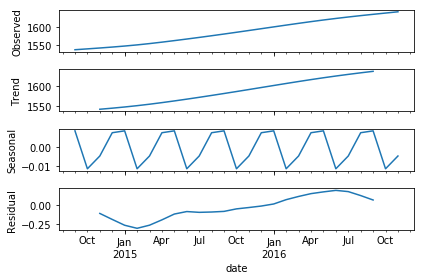

Shows a seasonal component of 0.5 rupees, hence no seasonality exists and prices are detrended!


In [10]:
#Replotting time series of Commodity = Onion and APMC = Lonand
temp = stationary[stationary.joined=='bajri_akole']
temp = temp[['trend','date','modal_price']]
temp.set_index('date', inplace=True)
result = seasonal_decompose(temp.trend,freq=4)
result.plot()
plt.show()
print("Shows a seasonal component of 0.5 rupees, hence no seasonality exists and prices are detrended!")

In [11]:
#Plotting modal price vs detrended prices of Commodity = Onion and APMC = Lonand 
trace0 = go.Scatter(
    x = temp.index,
    y = temp.modal_price,
    name = 'Modal Price',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dashdot')
)
trace1 = go.Scatter(
    x = temp.index,
    y = temp.trend,
    name = 'Detrended values',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,
        dash = 'dashdot')
)

data = [trace0, trace1]

layout = dict(title = 'Modal price vs detrended prices of Commodity = Onion and APMC = Lonand ',
              )

fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

In [13]:
#Taking non-stationary pairs of Commodity and APMC now
non_stationary = monthly_data[monthly_data["joined"].isin(ns)].reset_index(drop=True)
non_stationary.head()

,APMC,Commodity,Year,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,month,joined
0,kopargaon,soybean,2014,216,2954,3247,3138,2014-09-01,Ahmadnagar,9,soybean_kopargaon
1,umared,sorgum(jawar),2014,4,1775,1775,1775,2014-09-01,Nagpur,9,sorgum(jawar)_umared
2,rahata,maize,2014,8,1475,1475,1475,2014-09-01,Ahmadnagar,9,maize_rahata
3,savner,soybean,2014,137,2687,2966,2826,2014-09-01,Nagpur,9,soybean_savner
4,rahata,capsicum,2014,65,1842,2667,2258,2014-09-01,Ahmadnagar,9,capsicum_rahata


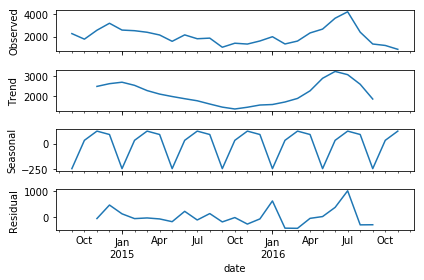

In [16]:
dat = non_stationary[non_stationary.joined=='capsicum_rahata']
dat = dat[['modal_price','date']]
dat.set_index('date', inplace=True)

import matplotlib.pyplot as pyplot
result = seasonal_decompose(dat.modal_price,freq=4)
result.plot()
pyplot.show()

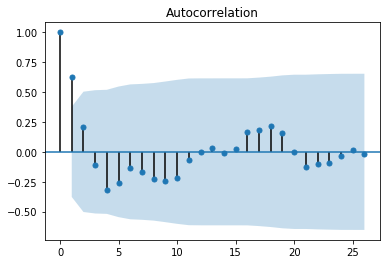

In [17]:
#Plotting acf of Commodity=Capsicum and APMC=Rahata
from statsmodels.graphics.tsaplots import plot_acf

plott = plot_acf(dat.modal_price, use_vlines=True)

## Detect seasonality type i.e "Additive" or "Multiplicative"

In [18]:
#Checking Seasonality type
def check_seasonality_type(df):
    types = list(df["joined"].unique())
    multt = list()
    addd = list()
    for t in types:
        temp = df.loc[df['joined']==t]
        temp = temp[["modal_price","joined","date"]] 
        temp.set_index('date', inplace=True)
        add = seasonal_decompose(temp.modal_price, model='additive',freq=4)
        mult = seasonal_decompose(temp.modal_price, model='multiplicative',freq=4)
        add_acf=sm.tsa.stattools.acf(add.resid, missing='conservative')*2
        add_acf=sum(add_acf)
        mult_acf=sm.tsa.stattools.acf(mult.resid, missing='conservative')*2
        mult_acf=sum(mult_acf)
        if add_acf<mult_acf:
            addd.append(t)
        else:
            multt.append(t)
    return addd,multt

add,mul=check_seasonality_type(non_stationary)
non_stationary['seasonality']='additive'
non_stationary.loc[non_stationary.joined.isin(mul),'seasonality']='multiplicative'

## De-seasonalising prices

In [19]:
#Function to add a column for detrended values as well as deseasonalised
def deseasonalise_prices(df):
    final=pd.DataFrame()
    types = list(df["joined"].unique())
    for t in types:
        temp = df.loc[df['joined']==t]
        temp = temp[["modal_price","joined","date","seasonality"]] 
        temp.set_index('date', inplace=True)
        if temp["seasonality"].all()=='additive':
            res = seasonal_decompose(temp.modal_price,model='additive',freq=4)
            temp['detrended']=res.trend.values
            temp['seasonal']=res.seasonal.values
            temp['deseasonalised']=temp['modal_price']-temp['seasonal']
        else:
            res = seasonal_decompose(temp.modal_price,model='multiplicative',freq=4)
            temp['detrended']=res.trend.values
            temp['seasonal']=res.seasonal.values
            temp['deseasonalised']=temp['modal_price']/temp['seasonal']
        res = df.merge(temp, on=["joined","modal_price","seasonality"])
        final = pd.concat([final,res],sort=False)
        final = final.dropna(how='any')
        final.reset_index(drop=True,inplace=True)
    return final

#Deseasonalising prices now
non_stationary = deseasonalise_prices(non_stationary)
non_stationary = non_stationary.drop(['seasonal'],axis=1)


In [25]:
#Saving the file
monthly_data.to_csv("/Users/gautamchauhan21/social cops/Analysis-of-Agricultural-data/monthly_data_2.csv",index=False)
non_stationary.to_csv("/Users/gautamchauhan21/social cops/Analysis-of-Agricultural-data/non_stationary.csv",index=False)
stationary.to_csv("/Users/gautamchauhan21/social cops/Analysis-of-Agricultural-data/stationary.csv",index=False)